### Implementing model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re 
import numpy as np
from sklearn.linear_model import LinearRegression
from pystout import pystout
import statsmodels.api as sm

In [2]:
df = pd.read_csv("data/full_dataset_sentiment_analysis.csv")

In [3]:
df['year'] = df['title'].str.extract('(\d{4})', expand=True)
df['country'] = df['title'].str.extract(r'Top Songs of (\d\d\d\d): (.*)')[1]

In [4]:
df = df.drop(columns=["enumerated_list", "lyrics_not_found"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.3  952 non-null    int64  
 1   Unnamed: 0.2  952 non-null    int64  
 2   Unnamed: 0.1  952 non-null    int64  
 3   Unnamed: 0    952 non-null    int64  
 4   songs         952 non-null    object 
 5   artist        952 non-null    object 
 6   title         952 non-null    object 
 7   lyrics        952 non-null    object 
 8   sentiment     952 non-null    object 
 9   neg           952 non-null    float64
 10  neu           952 non-null    float64
 11  pos           952 non-null    float64
 12  compound      952 non-null    float64
 13  year          952 non-null    object 
 14  country       952 non-null    object 
dtypes: float64(4), int64(4), object(7)
memory usage: 111.7+ KB


In [6]:
df_grouped = (
    df[['neg', 'pos', 'neu', 'year', 'country']].groupby(['country', 'year'])
    .agg(['mean'])
)

In [7]:
df_grouped = df_grouped.droplevel(axis=1, level=1).reset_index()

In [8]:
df_grouped["ratio"]=df_grouped["neg"]/df_grouped["pos"]
df_grouped

,country,year,neg,pos,neu,ratio
0,Australia,2019,0.109294,0.169353,0.721341,0.645363
1,Australia,2020,0.116071,0.138400,0.745541,0.838660
2,Australia,2021,0.118078,0.155805,0.726091,0.757856
3,Australia,2022,0.107183,0.150854,0.741902,0.710509
4,New Zealand,2019,0.117184,0.169539,0.713276,0.691191
5,New Zealand,2020,0.114917,0.142167,0.742917,0.808324
6,New Zealand,2021,0.111316,0.132595,0.756051,0.839523
7,New Zealand,2022,0.110341,0.145565,0.744129,0.758021
8,USA,2019,0.155149,0.125541,0.719270,1.235845
9,USA,2020,0.155580,0.119942,0.724493,1.297124


In [9]:
covid = pd.read_csv("data/covid policies/stay-at-home-covid.csv")

In [10]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202847 entries, 0 to 202846
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Entity                  202847 non-null  object
 1   Code                    202847 non-null  object
 2   Day                     202847 non-null  object
 3   stay_home_requirements  202847 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.2+ MB


In [11]:
covid["stay_home_requirements"].value_counts()

0    111364
2     50283
1     36230
3      4970
Name: stay_home_requirements, dtype: int64

Countries are grouped into four categories:

+ 0 - No measures
+ 1 - Recommended not to leave the house
+ 2 - Required to not leave the house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips
+ 3 - Required to not leave the house with minimal exceptions (e.g. allowed to leave only once every few days, or only one person can leave at a time, etc.)

In [12]:
covid = covid[(covid["Code"]=="AUS") | (covid["Code"]=="USA") | (covid["Code"]=="NZL")] 
covid["Entity"].value_counts()

Australia        1096
New Zealand      1096
United States    1096
Name: Entity, dtype: int64

In [13]:
covid["year"] = pd.DatetimeIndex(covid["Day"]).year
covid



,Entity,Code,Day,stay_home_requirements,year
7672,Australia,AUS,2020-01-01,0,2020
7673,Australia,AUS,2020-01-02,0,2020
7674,Australia,AUS,2020-01-03,0,2020
7675,Australia,AUS,2020-01-04,0,2020
7676,Australia,AUS,2020-01-05,0,2020
...,...,...,...,...,...
192978,United States,USA,2022-12-27,1,2022
192979,United States,USA,2022-12-28,1,2022
192980,United States,USA,2022-12-29,1,2022
192981,United States,USA,2022-12-30,1,2022


In [14]:
covid_by_year = (
    covid[["stay_home_requirements", "Entity", "year"]].groupby(['Entity', 'year'])
    .agg(['mean'])
)

covid_by_year = covid_by_year.droplevel(axis=1, level=1).reset_index()

covid_by_year

,Entity,year,stay_home_requirements
0,Australia,2020,1.183060
1,Australia,2021,1.030137
2,Australia,2022,0.120548
3,New Zealand,2020,0.393443
4,New Zealand,2021,0.657534
5,New Zealand,2022,0.000000
6,United States,2020,1.595628
7,United States,2021,1.169863
8,United States,2022,0.657534


In [15]:
covid_by_year["country"] = covid_by_year["Entity"]
covid_by_year= covid_by_year.drop(columns=["Entity"])

covid_by_year["country"]= covid_by_year["country"].str.replace(r'United States', 'USA')

df_grouped["year"]=df_grouped["year"].astype(np.int64)

In [16]:
covid_by_year_viz = covid_by_year[covid_by_year["year"]<=2021]


covid_by_year_viz = (
    covid_by_year_viz[["stay_home_requirements", "country"]].groupby(['country'])
    .agg(['mean'])
)

covid_by_year_viz = covid_by_year_viz.droplevel(axis=1, level=1).reset_index()
covid_by_year_viz


,country,stay_home_requirements
0,Australia,1.106599
1,New Zealand,0.525488
2,USA,1.382746


In [17]:
df_full = pd.merge(df_grouped,covid_by_year,how='left',left_on=["country", str("year")], right_on=["country", str("year")])

In [18]:
df_full = df_full.replace(np.nan, 0)
df_full

,country,year,neg,pos,neu,ratio,stay_home_requirements
0,Australia,2019,0.109294,0.169353,0.721341,0.645363,0.000000
1,Australia,2020,0.116071,0.138400,0.745541,0.838660,1.183060
2,Australia,2021,0.118078,0.155805,0.726091,0.757856,1.030137
3,Australia,2022,0.107183,0.150854,0.741902,0.710509,0.120548
4,New Zealand,2019,0.117184,0.169539,0.713276,0.691191,0.000000
5,New Zealand,2020,0.114917,0.142167,0.742917,0.808324,0.393443
6,New Zealand,2021,0.111316,0.132595,0.756051,0.839523,0.657534
7,New Zealand,2022,0.110341,0.145565,0.744129,0.758021,0.000000
8,USA,2019,0.155149,0.125541,0.719270,1.235845,0.000000
9,USA,2020,0.155580,0.119942,0.724493,1.297124,1.595628


Text(0.5, 1.0, 'Ratio negative/positive sentiments')

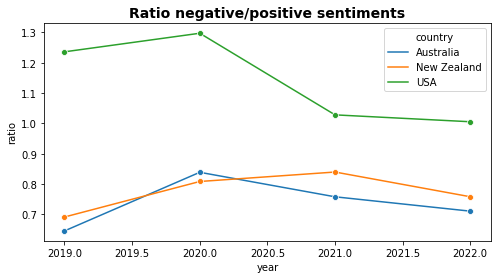

In [19]:
fig, g = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df_full['year'], y=df_full['ratio'], hue=df_full["country"], marker='o')

g.set_title('Ratio negative/positive sentiments', fontweight="bold", fontsize=14) # setting title

Text(0.5, 1.0, 'Ratio negative/positive sentiments')

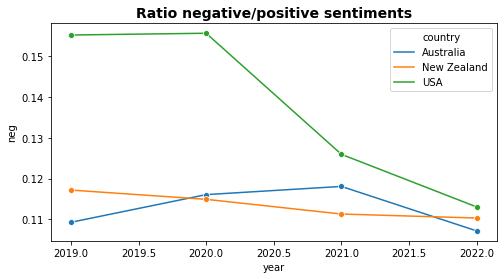

In [20]:
fig, g = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df_full['year'], y=df_full['neg'], hue=df_full["country"], marker='o')

g.set_title('Ratio negative/positive sentiments', fontweight="bold", fontsize=14) # setting title

Text(0.5, 1.0, 'Ratio negative/positive sentiments')

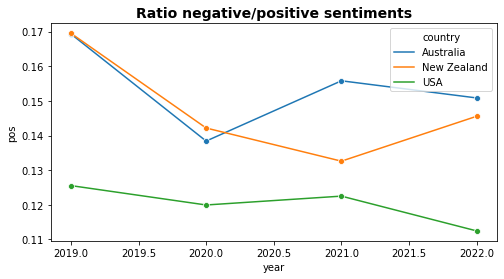

In [21]:
fig, g = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df_full['year'], y=df_full['pos'], hue=df_full["country"], marker='o')

g.set_title('Ratio negative/positive sentiments', fontweight="bold", fontsize=14) # setting title

In [22]:
# Focusing on the change in sentiment

df_pivot = df_full.pivot(values="ratio", index="country", columns="year")
df_pivot

year,2019,2020,2021,2022
country,,,,
Australia,0.645363,0.838660,0.757856,0.710509
New Zealand,0.691191,0.808324,0.839523,0.758021
USA,1.235845,1.297124,1.028020,1.005314


In [23]:
df_pivot["diff_2020_2019"]=df_pivot[2020]-df_pivot[2019]
df_pivot["diff_2021_2019"]=df_pivot[2021]-df_pivot[2019]
df_pivot["diff_2022_2019"]=df_pivot[2022]-df_pivot[2019]

In [24]:
df_pivot

year,2019,2020,2021,2022,diff_2020_2019,diff_2021_2019,diff_2022_2019
country,,,,,,,
Australia,0.645363,0.838660,0.757856,0.710509,0.193297,0.112493,0.065146
New Zealand,0.691191,0.808324,0.839523,0.758021,0.117132,0.148331,0.066830
USA,1.235845,1.297124,1.028020,1.005314,0.061279,-0.207825,-0.230531


In [25]:
df_pivot_covid = df_full.pivot(values="stay_home_requirements", index="country", columns="year")
df_pivot_covid["diff_2020_2019"]=df_pivot_covid[2020]-df_pivot_covid[2019]
df_pivot_covid["diff_2021_2019"]=df_pivot_covid[2021]-df_pivot_covid[2019]
df_pivot_covid["diff_2022_2019"]=df_pivot_covid[2022]-df_pivot_covid[2019]
df_pivot_covid

year,2019,2020,2021,2022,diff_2020_2019,diff_2021_2019,diff_2022_2019
country,,,,,,,
Australia,0.0,1.183060,1.030137,0.120548,1.183060,1.030137,0.120548
New Zealand,0.0,0.393443,0.657534,0.000000,0.393443,0.657534,0.000000
USA,0.0,1.595628,1.169863,0.657534,1.595628,1.169863,0.657534


## Implementing a Diff-in-Diff model

Our proposed model is the following:
$Y= \beta_0 + \beta_1covid + \beta_2lockdown + \beta_3(covid*lockdown) + \epsilon$

Where:

+ $Y = \Delta_{sentiment}$, considering as main measure a ratio negative/positive sentiment in song lyrics
+ $\beta_1covid$ are time fixed effects (pre-covid/post covid)
+ $\beta_2lockdown$ are group (country) fixed effects
+ $\beta_3(covid*lockdown)$ are the effects of the treatment variable

Treatment: strict lockdowns at the country level.

In [26]:
# First we restructure our dataset

df.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,songs,artist,title,lyrics,sentiment,neg,neu,pos,compound,year,country
0,0,3,3,3,Drip Too Hard,"Lil Baby, Gunna",Top Songs of 2019: USA,"['hard', 'run', 'back', 'turbo', 'get', 'bigge...","{'neg': 0.266, 'neu': 0.694, 'pos': 0.04, 'com...",0.266,0.694,0.040,-0.9974,2019,USA
1,1,5,5,5,MIDDLE CHILD,J. Cole,Top Songs of 2019: USA,"['child', 'good', 'tminu', 'nigga', 'countin',...","{'neg': 0.161, 'neu': 0.7, 'pos': 0.139, 'comp...",0.161,0.700,0.139,-0.9113,2019,USA
2,2,6,6,6,SICKO MODE,Travis Scott,Top Songs of 2019: USA,"['mode', 'astro', 'sun', 'freezin', 'cold', 't...","{'neg': 0.139, 'neu': 0.733, 'pos': 0.129, 'co...",0.139,0.733,0.129,-0.6941,2019,USA
3,3,7,7,7,Suge,DaBaby,Top Songs of 2019: USA,"['suge', 'pooh', 'fool', 'one', 'ha', 'oh', 'l...","{'neg': 0.184, 'neu': 0.628, 'pos': 0.188, 'co...",0.184,0.628,0.188,-0.9576,2019,USA
4,4,8,8,8,7 rings,Ariana Grande,Top Songs of 2019: USA,"['ring', 'breakfast', 'tiffani', 'bottl', 'bub...","{'neg': 0.116, 'neu': 0.652, 'pos': 0.232, 'co...",0.116,0.652,0.232,0.9064,2019,USA


In [27]:
# We keep only Australia and NZ, and 2019 and 2020

df_diff = df[(df["country"]=="USA") | (df["country"]=="New Zealand")]
df_diff = df_diff[(df_diff["year"]=="2019") | (df_diff["year"]=="2020") | (df_diff["year"]=="2021")]


In [28]:
# Time variable
df_diff["time"]=np.where(df_diff["year"]=="2019", 0, 1)
# group variable (treatment)
df_diff['group'] = np.where(df_diff['country']=="USA" , 1,0 )
#creating interaction variable
df_diff['did'] = df_diff['time'] * df_diff['group']

In [29]:
df_diff["ratio"]=df_diff["neg"]/df_diff["pos"]

In [44]:
#Splitting variables into dependent (x) and independent (y) variables
#x = df_diff.iloc[:,9:12]
x = df_diff.loc[:, ["time","group","did"]]
y = df_diff["ratio"]

# There are three null values in y and 4 inf, we replace with 0 to be able to run the regression

y = y.replace(np.nan, 0)
y.replace([np.inf, -np.inf], 0, inplace=True)

In [117]:
y.isnull().sum()

0

In [118]:
number_inf = y[y == np.inf].count()
number_inf

0

In [119]:
model = LinearRegression()
model.fit(x, y)


LinearRegression()

In [120]:
model.coef_

array([-0.00401243,  0.03796444, -0.01089846])

In [45]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.428
Date:                Tue, 21 Feb 2023   Prob (F-statistic):              0.234
Time:                        11:18:29   Log-Likelihood:                -1210.1
No. Observations:                 456   AIC:                             2428.
Df Residuals:                     452   BIC:                             2445.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9049      0.396      4.810      0.0

The model is not significant. Improving Y variable:

In [34]:
df_cov = pd.read_csv("data/lists of songs/full_dataset.csv")

In [35]:
df_cov.columns

Index(['Unnamed: 0', 'songs', 'title', 'lyrics', 'enumerated_list',
       'lyrics_not_found', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'year', 'country', 'artist'],
      dtype='object')

In [36]:
df_cov = df_cov.loc[:, ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'year', 'country', 'artist', 'songs']]

In [37]:
df_cov["year"]=df_cov["year"].astype("str")

In [38]:
df_cov["minor_mode"]=np.where(df_cov["mode"]==1, 0, 1)

In [97]:
# Resetting df_diff

df_diff = df[(df["country"]=="USA") | (df["country"]=="New Zealand")]
#df_diff = df_diff[(df_diff["year"]=="2019") | (df_diff["year"]=="2020")]
df_diff = df_diff[(df_diff["year"]=="2019") | (df_diff["year"]=="2020") | (df_diff["year"]=="2021")]
# Time variable
df_diff["time"]=np.where(df_diff["year"]=="2019", 0, 1)
# group variable (treatment)
df_diff['group'] = np.where(df_diff['country']=="New Zealand" , 0,1 )
#creating interaction variable
df_diff['did'] = df_diff['time'] * df_diff['group']

In [98]:
df_diff_2 = pd.merge(df_diff,df_cov,how='left',left_on=["country", "year", "artist", "songs"], right_on=["country", "year", "artist", "songs"])

In [99]:
df_diff_2 = df_diff_2.replace(np.nan, 0)
df_diff_2.replace([np.inf, -np.inf], 0, inplace=True)

As dependent variable, we are defining a 'gloom index'. This is defined as follows:

$Y_{gloom index}=\frac{(1-valence) + (1-danceability)}{2} + negative lyrics*speechiness*2$

This index gives different weights to different variables. 2/3 of the final value is given by the negative sentiments of the lyrics (note that the amount of negative words are weighted by the speechines or lyrical density of the song (i.e. the number of words of the song, standarized according to song length). Finally, 1/3 of the final value of the index is given by adding two Spotify features: (1-) valence (that is, happiness of the song), and (1-) danceability (that is, how much you can dance to the song). Both are substracted from 1 to get the inverse of the actual value. 

<AxesSubplot:>

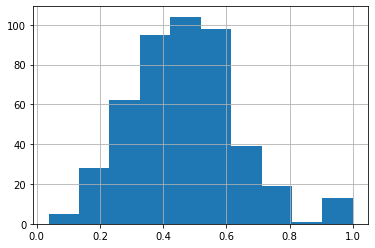

In [100]:
df_diff_2["gloom_index"]=(((1-df_diff_2["valence"])+(1-df_diff_2['danceability']))/2+df_diff_2["neg"]*df_diff_2["speechiness"]*2)
df_diff_2["gloom_index"].hist()

In [101]:
df_diff_2.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'songs',
       'artist', 'title', 'lyrics', 'sentiment', 'neg', 'neu', 'pos',
       'compound', 'year', 'country', 'time', 'group', 'did', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'minor_mode',
       'gloom_index'],
      dtype='object')

In [102]:
#Splitting variables into dependent (x) and independent (y) variables
#x = df_diff.iloc[:,9:12]
x = df_diff_2.loc[:, ["time","group","did"]]
y = df_diff_2["gloom_index"]

# There are three null values in y and 4 inf, we replace with 0 to be able to run the regression

y = y.replace(np.nan, 0)
y.replace([np.inf, -np.inf], 0, inplace=True)

In [103]:
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [104]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            gloom_index   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.653
Date:                Tue, 21 Feb 2023   Prob (F-statistic):            0.00324
Time:                        11:36:37   Log-Likelihood:                 158.98
No. Observations:                 464   AIC:                            -310.0
Df Residuals:                     460   BIC:                            -293.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4768      0.020     24.249      0.0

With our 'gloom index' as dependent variable we have significance 😁

In [110]:
def x_y (treated, y_selected, df):
    dataset = df[(df["country"]==treated) | (df["country"]=="New Zealand")]
    dataset = dataset[(dataset["year"]=="2019") | (dataset["year"]=="2020") | (dataset["year"]=="2021")]

    # Time variable
    dataset["time"]=np.where(dataset["year"]=="2019", 0, 1)
    # group variable (treatment)
    dataset['group'] = np.where(dataset['country']=="New Zealand", 0,1)
    #creating interaction variable
    dataset['did'] = dataset['time'] * dataset['group']
    
    #Splitting variables into dependent (x) and independent (y) variables

    x = dataset.loc[:, ["time","group","did"]]
    y = dataset[y_selected]
    y = y.replace(np.nan, 0)
    y.replace([np.inf, -np.inf], 0, inplace=True)


    return x, y

In [111]:
df_merged = pd.merge(df,df_cov,how='left',left_on=["country", "year", "artist", "songs"], right_on=["country", "year", "artist", "songs"])
df_merged = df_merged.replace(np.nan, 0)
df_merged.replace([np.inf, -np.inf], 0, inplace=True)

<AxesSubplot:>

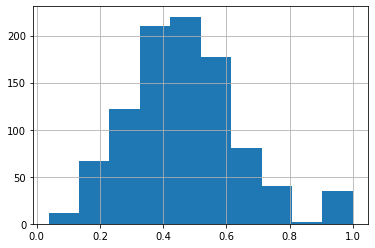

In [112]:
df_merged["gloom_index"]=(((1-df_merged["valence"])+(1-df_merged['danceability']))/2+df_merged["neg"]*df_merged["speechiness"]*2)
df_merged["gloom_index"].hist()

In [113]:
df_merged["ratio"]=df_merged["neg"]/df_merged["pos"]

In [114]:
# Instantiating models

x, y= x_y(treated="Australia", y_selected="ratio", df=df_merged)
X2 = sm.add_constant(x)
model1 = sm.OLS(y,X2).fit()

x, y= x_y(treated="USA", y_selected="ratio", df=df_merged)
X2 = sm.add_constant(x)
model2 = sm.OLS(y,X2).fit()

x, y= x_y(treated="Australia", y_selected="gloom_index", df=df_merged)
X2 = sm.add_constant(x)
model3 = sm.OLS(y,X2).fit()

x, y= x_y(treated="USA", y_selected="gloom_index", df=df_merged)
X2 = sm.add_constant(x)
model4 = sm.OLS(y,X2).fit()

In [115]:
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:            gloom_index   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.653
Date:                Tue, 21 Feb 2023   Prob (F-statistic):            0.00324
Time:                        11:38:49   Log-Likelihood:                 158.98
No. Observations:                 464   AIC:                            -310.0
Df Residuals:                     460   BIC:                            -293.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4768      0.020     24.249      0.0

In [118]:
# =============================================================================
# Print result
# =============================================================================
pystout(models=[model1,model2,model3,model4],
        file='test_table.tex',
        addnotes=['* Significant at the 0.05 level'],
        digits=2,
        endog_names=['AUS','USA','AUS','USA'],
        varlabels={'const':'Constant','time':'Time (Covid)','group':'Country', 'did':'Treatment(DiD)'},
        #addrows={'Test':['A','Test','Row','Here','Too']},
        mgroups={'Sentiment':[1,2],'Gloom Index':[3,4]},
        modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}','fvalue':'F-stat'}
        )

c:\Users\danid\anaconda3\lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
c:\Users\danid\anaconda3\lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
c:\Users\danid\anaconda3\lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
